In [31]:
pip install sklearn

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=fda6e0448e3f41fa6ba4263b641b07d0bb7bfb4d844b9dfa1e3d8ede2b9aec86
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn


In [120]:
import numpy as np # linear algebra
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
#import seaborn as sns # Plotting library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import keras
import tensorflow as tf

from keras.utils import np_utils
from sklearn.datasets import load_files
from tqdm import tqdm
from collections import Counter
import itertools
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import pathlib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir_train = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Assignment_data/FoodImage/train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Assignment_data/FoodImage/test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Total images in train folder: ",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Total images in test folder: ",image_count_test)

Total images in train folder:  407
Total images in test folder:  90


In [6]:
## preparing the dataset

batch_size = 8
img_height = 256
img_width = 256

In [7]:
## listing out all the classes in given dataset

class_names = sorted([item.name for item in data_dir_train.glob('*')][:6])
print(class_names)

['ApplePie', 'BagelSandwich', 'Bibimbop', 'Bread', 'FriedRice', 'Pork']


In [8]:
train_ratio = 0.8
validation_ratio = 0.2

In [64]:
# Create an ImageDataGenerator and specify the data preprocessing options
data_generator = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
data_generator1 = ImageDataGenerator(rescale=1.0/255)

# Use the flow_from_directory function to load and split the data
train_data_generator = data_generator.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=42
)

validation_data_generator = data_generator.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    shuffle=True,
    subset='validation',
    seed=42
)

test_generator = data_generator1.flow_from_directory(
        data_dir_test,
        target_size=(img_height, img_width),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)


Found 328 images belonging to 6 classes.
Found 79 images belonging to 6 classes.
Found 90 images belonging to 6 classes.


In [10]:
num_train = len(train_data_generator.filenames)
num_valid = len(validation_data_generator.filenames)
num_test = len(test_generator.filenames)

print(num_train, num_valid, num_test)

328 79 90


In [11]:
base_model = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = MaxAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.95)(x)
# and a logistic layer
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = True

94765736/94765736 [==============================] - 1s 0us/step


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [13]:
from keras.optimizers import Adam

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
             metrics=['accuracy'])

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


# train the model
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/Image_classification_food/FoodImage/efficientNet.hdf5', verbose=1,
                               save_best_only=True)

scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8, verbose=1)

early_stopper = EarlyStopping(monitor='val_loss', patience=10,
                              verbose=0, restore_best_weights=True)

history = model.fit(train_data_generator,
                    steps_per_epoch=40,
                    epochs=40,
                    verbose=0,
                    callbacks=[checkpointer, scheduler, early_stopper],
                    validation_data=validation_data_generator,
                    validation_steps=10)


Epoch 1: val_loss improved from inf to 1.97893, saving model to /content/drive/MyDrive/Colab Notebooks/Image_classification_food/FoodImage/efficientNet.hdf5

Epoch 2: val_loss did not improve from 1.97893

Epoch 3: val_loss did not improve from 1.97893

Epoch 4: val_loss did not improve from 1.97893

Epoch 5: val_loss improved from 1.97893 to 1.94180, saving model to /content/drive/MyDrive/Colab Notebooks/Image_classification_food/FoodImage/efficientNet.hdf5

Epoch 6: val_loss did not improve from 1.94180

Epoch 7: val_loss did not improve from 1.94180

Epoch 8: val_loss did not improve from 1.94180

Epoch 9: val_loss improved from 1.94180 to 1.93338, saving model to /content/drive/MyDrive/Colab Notebooks/Image_classification_food/FoodImage/efficientNet.hdf5

Epoch 10: val_loss improved from 1.93338 to 1.82364, saving model to /content/drive/MyDrive/Colab Notebooks/Image_classification_food/FoodImage/efficientNet.hdf5

Epoch 11: val_loss improved from 1.82364 to 1.75528, saving model 

In [16]:
model.evaluate(validation_data_generator)

10/10 [==============================] - 4s 404ms/step - loss: 0.1915 - accuracy: 0.9241


[0.19149310886859894, 0.9240506291389465]

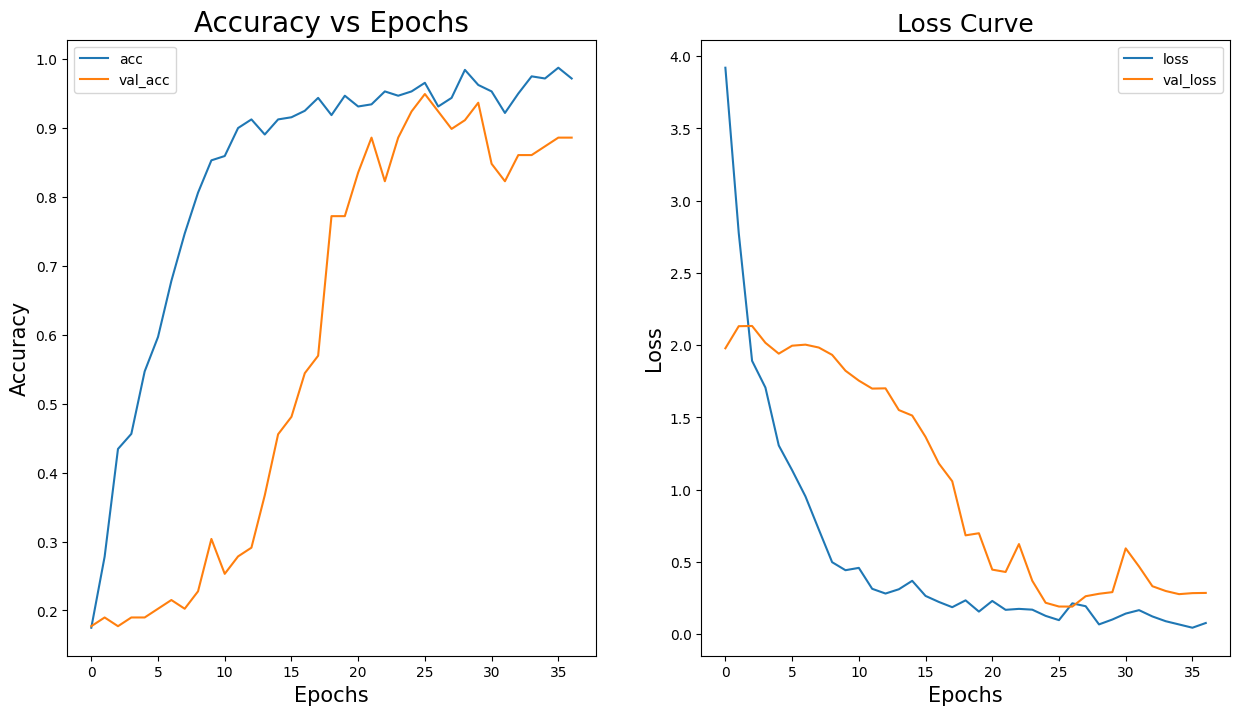

In [17]:
def model_performance_graphs():

    fig, axes = plt.subplots(1, 2, figsize = (15, 8))

    axes[0].plot(history.epoch, history.history['accuracy'], label = 'acc')
    axes[0].plot(history.epoch, history.history['val_accuracy'], label = 'val_acc')
    axes[0].set_title('Accuracy vs Epochs', fontsize = 20)
    axes[0].set_xlabel('Epochs', fontsize = 15)
    axes[0].set_ylabel('Accuracy', fontsize = 15)
    axes[0].legend()

    axes[1].plot(history.epoch, history.history['loss'], label = 'loss')
    axes[1].plot(history.epoch, history.history['val_loss'], label="val_loss")
    axes[1].set_title("Loss Curve",fontsize=18)
    axes[1].set_xlabel("Epochs",fontsize=15)
    axes[1].set_ylabel("Loss",fontsize=15)
    axes[1].legend()

    plt.show()

model_performance_graphs()

In [14]:
def preprocess_images(path):
    img = image.load_img(path, target_size=(256, 256))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_array / 255.0

    return img_preprocessed

In [13]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Image_classification_food/FoodImage/efficientNet.hdf5')

In [90]:
img_path = "/content/drive/MyDrive/Colab Notebooks/Assignment_data/FoodImage/test/Bibimbop/B010316XX_02335.jpg"
img = preprocess_images(img_path)

prediction = loaded_model.predict(img)

predicted_class_index = np.argmax(prediction)

class_labels = ['ApplePie', 'BagelSandwich', 'Bibimbop', 'Bread', 'FriedRice', 'Pork']
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", predicted_class_label)

1/1 [==============================] - 0s 24ms/step
Predicted class: Bibimbop


In [91]:
print(prediction, predicted_class_index)

[[3.5066368e-08 3.4307985e-07 9.9999797e-01 2.6417634e-08 1.3869527e-06
  3.2508672e-07]] 2


In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [95]:
predictions_new = loaded_model.predict(x=test_generator, verbose=1)

90/90 [==============================] - 8s 76ms/step


In [110]:
y_true=test_generator.classes
y_pred=np.argmax(predictions_new,axis=1)

In [106]:
cm = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
[[14  0  0  0  0  1]
 [ 1 11  0  2  0  1]
 [ 0  0 15  0  0  0]
 [ 1  0  0 13  1  0]
 [ 0  0  0  1 14  0]
 [ 0  0  0  0  0 15]]


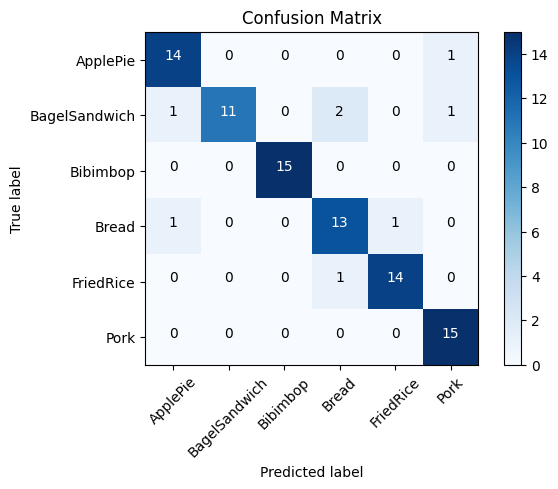

In [116]:
cm_plot_labels = class_labels
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [117]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_labels))

               precision    recall  f1-score   support

     ApplePie       0.88      0.93      0.90        15
BagelSandwich       1.00      0.73      0.85        15
     Bibimbop       1.00      1.00      1.00        15
        Bread       0.81      0.87      0.84        15
    FriedRice       0.93      0.93      0.93        15
         Pork       0.88      1.00      0.94        15

     accuracy                           0.91        90
    macro avg       0.92      0.91      0.91        90
 weighted avg       0.92      0.91      0.91        90

